## Metrics: Evaluating Model Accuracy

Let's return to the lending-based example of Logistic Regression from the previous lesson. How can we rigorously evaluate the quantitative accuracy of our model? This question is more complex than it sounds. Recall that we constructed a model of default probabilities as follows:

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

raw_default_data_df = pd.read_csv("data/raw_default_data.csv")
x = np.array(raw_default_data_df['Balance as % of Income'])
X = x.reshape(-1,1)
y = np.array(raw_default_data_df['Defaulted? (0/1 = no/yes)'])
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The output of this model was a probability of default for various values of the customer's credit card balance as a percentage of their income:

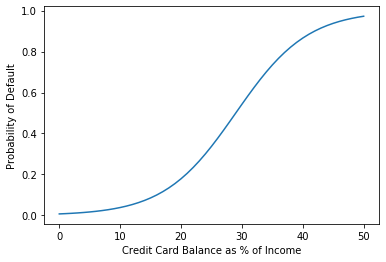

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
grid_x_values = np.arange(0, 51).reshape(-1,1)
probabilities = logistic.predict_proba(grid_x_values)
prob_default = probabilities[:,1]
plt.xlabel("Credit Card Balance as % of Income")
plt.ylabel("Probability of Default")
plt.plot(grid_x_values,prob_default)
plt.show()

If we are running a bank, we need a way to turn these rather nebulous probabilities into concrete "yes or no" decisions. Do we lend to this prospective borrower, or not? In order to make this decision, we must define a *cutoff* value for the probability of default - for example, we might say that "we will not lend to a borrower with greater than ten percent chance of default." But the question is: how do we choose the cutoff value that makes us the most money? We need to choose a cutoff value that achieves the best possible combination of the following two attributes:

1. Maximize True Positives (Correctly Mark Bad Borrowers as Bad)
2. Minimize False Positives (Do Not Mark Good Borrowers as Bad)

Our bank clearly must care a lot about objective (1) from the list above, as giving bad loans that are not repaid will be very expensive. However, our bank must also care a lot about objective (2), because every good loan that we do not issue represents a lost opportunity to earn profit. 

### Choosing the Right Cutoff Value using ROC Curves

How can we figure out the right cutoff value that maximizes our profit while minimizing our risk? We could manually test many different cutoff values, but this would be time consuming and inefficient. What automated procedure can we use to easily see the results of trying many different cutoff values? The answer is to construct a graph called an **ROC curve**. The acronym "ROC" stands for "Receiver Operating Characteristic," and derives from the historical use of these graphs in analysis of United States military radar systems during World War II. An ROC curve consists of the following two variables:

1. The True Positive Rate ($y$ axis)
2. The False Positive Rate ($x$ axis)

Each point on the ROC curve corresponds to a different cutoff value. Let's see what one of these curves looks like: 

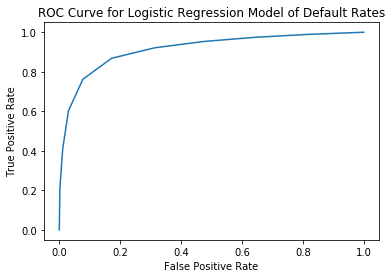

In [19]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

probabilities = logistic.predict_proba(X)
default_probability = probabilities[:,1]
false_positive_rate, true_positive_rate, cutoffs = roc_curve(y, default_probability)

plt.title("ROC Curve for Logistic Regression Model of Default Rates")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

In the graph above, the True Positive Rate is rate at which our model predicts that true bad borrowers (who actually defaulted) will default. The false positive rate is the fraction of good borrowers (who would have been profitable for our bank to lend money to) that we rejected because the model incorrectly identified them as a risk. Our business goal is to choose a cutoff value that has a high true positive rate, but a low false positive rate. Suppose that we require a true positive rate of 95%, meaning that 95% of bad borrowers are correctly identified and rejected - this will protect our bank from the significant risk of making bad loans that are not repaid. Let's inspect the true positive rate list:

In [22]:
true_positive_rate

array([0.        , 0.21019108, 0.4118896 , 0.6029724 , 0.76220807,
       0.86836518, 0.92144374, 0.95329087, 0.97452229, 0.98938429,
       1.        ])

So it looks like at index `7`, our true positive rate exceeds 95%. What is the corresponding false positive rate?

In [5]:
false_positive_rate[7]

0.47448015122873344

So by erroneously rejecting 47% of the "good" loan applications, we can correctly identify 95% of the bad loans. Is this a good compromise? It depends on exactly how expensive bad loans can be, which is a business detail that is beyond the scope of this course. If we assume that this is a favorable compromise for our bank, then we must ask: what cutoff value is necessary to achieve this? The answer is:

In [7]:
cutoffs

array([1.9723436 , 0.9723436 , 0.93776611, 0.86591925, 0.73460196,
       0.54260808, 0.3370642 , 0.17892377, 0.08541822, 0.03848806,
       0.01686659])

In [8]:
cutoffs[7]

0.17892376857716585

All customers to whom our model assigns a default probability greater than or equal to this cutoff value are considered to be "high risk" and rejected, while customers with a default probability lower than this value are considered "low risk" and accepted. 

### Evaluating our Model

So how "good" is our logistic regression model? The answer is: it depends on the alternatives. We have seen that our model has the tradeoffs described above: its accuracy is sufficient to identify 95% of the bad borrowers, but only if we throw away almost half of our prospective good borrowers, which will greatly reduce the profit that we can earn. A better predictive model would result in a *steeper* ROC curve, which very quickly attains a high true positive rate with only a small increase in the false positive rate. The "steepness" of the ROC curve, and thus the quality of the model, can be quantified by measuring the Area Under the Curve (AUC) metric:

In [9]:
from sklearn import metrics
metrics.auc(false_positive_rate, true_positive_rate)

0.9147953716301638

It is common to regard models with larger the AUC values as "better" than models with smaller AUC values - however, it is important to always remember that in a business context the value of the model is how much money it can earn for us. The optimal combination of true and false positive rates will always depend on the particular business context in which the model is deployed.

### Additional Steps for Rigorous Testing

We have now seen an example of how to check the accuracy of our model and assess its business value. However, there are further concerns that we must address in order to make our model ready for production use in real applications. The chief remaining concern is *generalization* - how do we ensure that our model performs well on customers with attributes that were not in our training set? As we begin to use more and more complicated models, there is a risk that our models will suffer from *overfitting* - becoming so complex and specifically tuned to the training set that they lose their ability to make accurate predictions in the real world. It is more intuitive to demonstrate the concept of overfitting and its mitigation when using other machine learning techniques, so we are going to defer discussion of this area until a later lesson. 

<span style="color:blue;font-weight:bold">Exercise</span>: Predicting Credit Card Default. Revisit the logistic regression model that you prepared in the final exercise of the previous lesson. In the code cell below, recreate your model and then plot an ROC curve based on your models predictions. Store the output of the `roc_curve` function in these three variables: `fps, tps, thresh` in order for your code to pass validation. Finally, compute the AUC for your model and store it in the variable `auc`.

In [30]:
logistic = LogisticRegression(solver="lbfgs")
df = pd.read_csv("data/credit_card_exercise.csv")
logistic.fit(df[["Months in Good Standing"]], df["Defaulted? (0/1 = no/yes)"])

months_in_good_standing = np.array([3, 6, 12, 18, 24, 36, 48])
probabilities_by_months = np.array([0.35, 0.33, 0.20, 0.07, 0.03, 0.02, 0.01])

pred = logistic.predict_proba(df[["Months in Good Standing"]])
default_probability = pred[:,1]

fps, tps, thresh = roc_curve(df["Defaulted? (0/1 = no/yes)"], default_probability) 
              
auc = metrics.auc(fps, tps)
auc

0.7991784988181623

In [30]:
import math
check_variable_definition("fps", "tps", "thresh")
assert isinstance(fps, np.ndarray), "<code>fps</code> should be a numpy array"
assert isinstance(tps, np.ndarray), "<code>tps</code> should be a numpy array"
assert isinstance(thresh, np.ndarray), "<code>tps</code> should be a numpy array"

assert len(fps) == 8
assert len(tps) == 8
assert len(thresh) == 8

assert math.isclose(sum(fps), 3.70, abs_tol=1e-2), "Check your <code>fps</code> values"
assert math.isclose(sum(tps), 5.79, abs_tol=1e-2), "Check your <code>tps</code> values"
assert math.isclose(sum(thresh), 2.38, abs_tol=1e-2), "Check your <code>thresh</code> values"

check_variable_definition("auc")
assert math.isclose(auc, 0.799, abs_tol=1e-3), "Check your <code>auc</code> value"
success()

In [31]:
fps, tps

(array([0.        , 0.10851419, 0.22036728, 0.35392321, 0.50918197,
        0.67111853, 0.83472454, 1.        ]),
 array([0.        , 0.34653465, 0.67326733, 0.87128713, 0.94059406,
        0.97029703, 0.99009901, 1.        ]))

In [32]:
thresh

array([1.37345688, 0.37345688, 0.29706937, 0.17522389, 0.09649396,
       0.05095288, 0.01338603, 0.00341697])

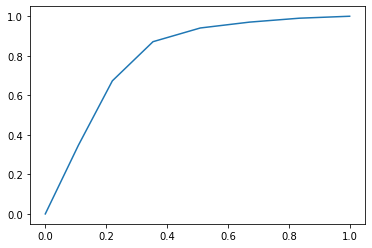

In [33]:
plt.plot(fps, tps)